In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved
# Licensed under the MIT License.
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import imageio
from pygifsicle import optimize # requires `sudo apt-get install gifsicle`

from temporal_cluster_matching import utils, DataInterface, algorithms

In [2]:
PC_SUBSCRIPTION_KEY = "" # Set to your Planetary Computer API key 

## Sentinel 2 / Solar farm data demo

In [3]:
geoms = utils.get_solar_farm_geoms("../data/")
len(geoms)

935

In [4]:
dataloader = DataInterface.PlanetaryComputerS2DataLoader(geoms, pc_subscription_key=PC_SUBSCRIPTION_KEY)

In [5]:
%%time
rgb_images, dates = dataloader.get_rgb_stack_from_geom(0, buffer=200, show_outline=True)

CPU times: user 1.26 s, sys: 117 ms, total: 1.38 s
Wall time: 58 s


In [6]:
%%time
data_images, masks, dates = dataloader.get_data_stack_from_geom(0, buffer=200)

CPU times: user 1.01 s, sys: 80.1 ms, total: 1.09 s
Wall time: 30 s


In [7]:
%%time
divergence_values = algorithms.calculate_change_values(data_images, masks, n_clusters=64, use_minibatch=True)

CPU times: user 2min, sys: 655 ms, total: 2min
Wall time: 30 s


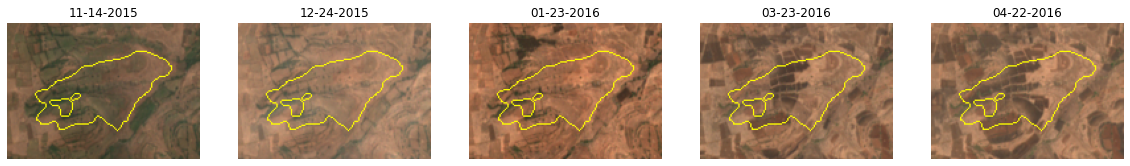

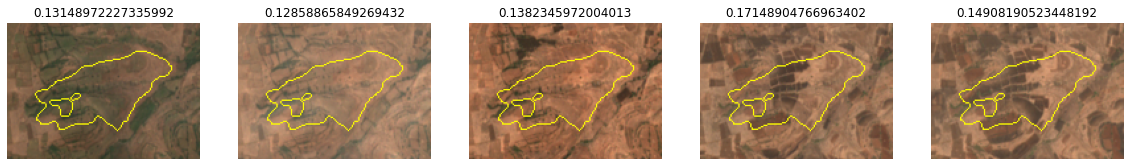

In [8]:
utils.show_images(rgb_images[:5], dates[:5])
utils.show_images(rgb_images[:5], divergence_values[:5])

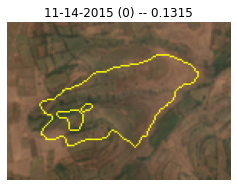

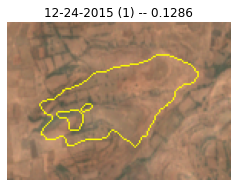

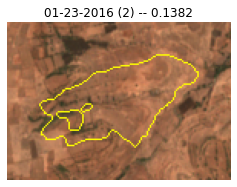

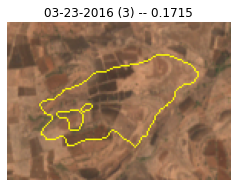

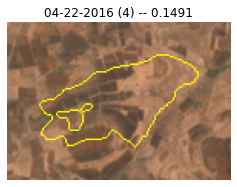

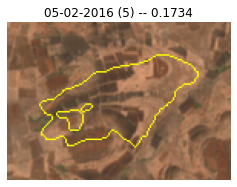

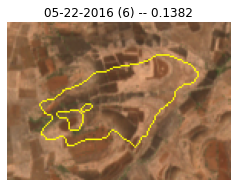

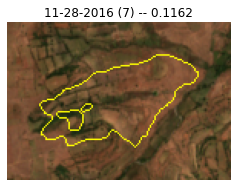

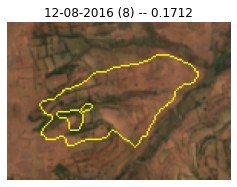

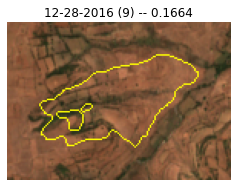

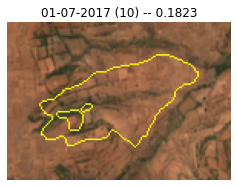

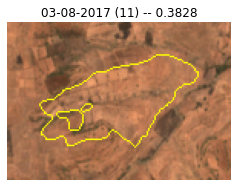

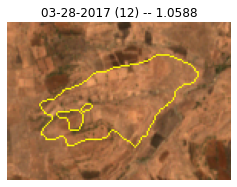

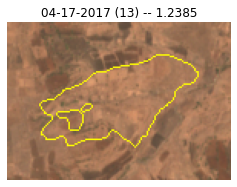

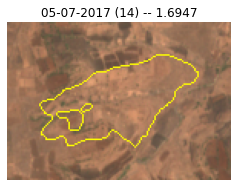

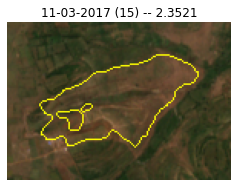

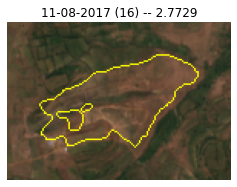

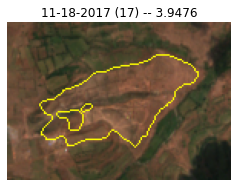

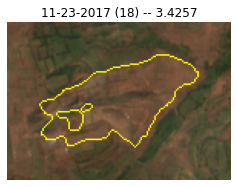

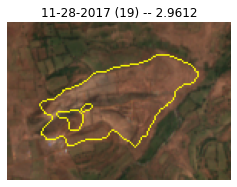

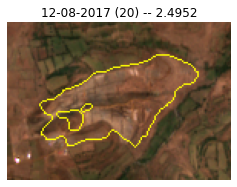

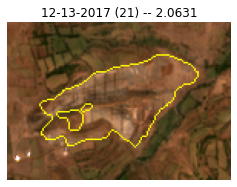

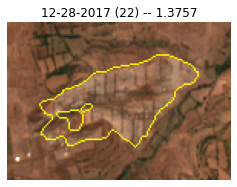

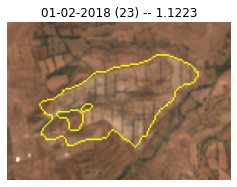

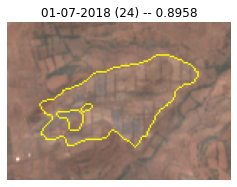

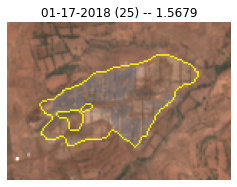

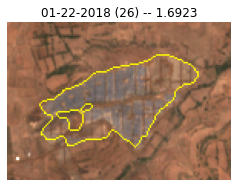

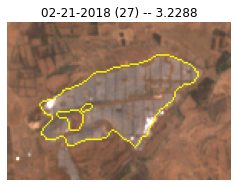

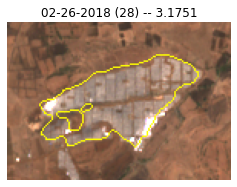

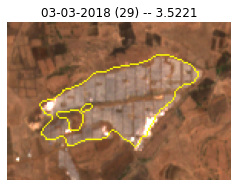

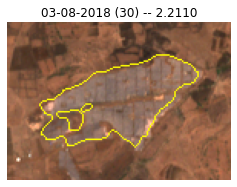

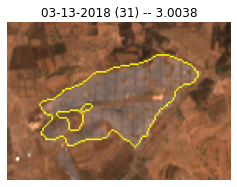

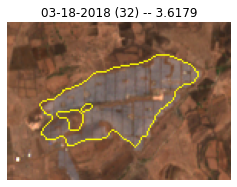

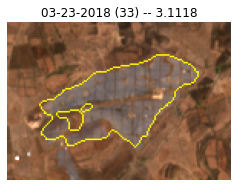

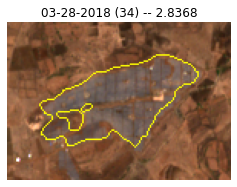

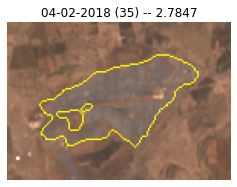

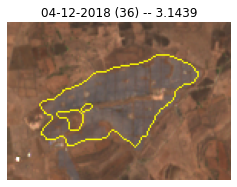

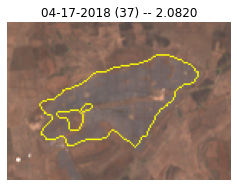

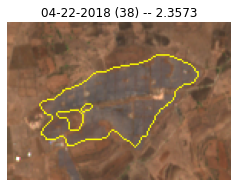

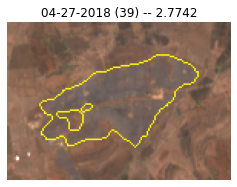

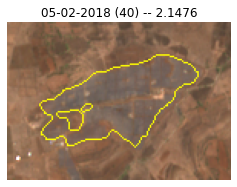

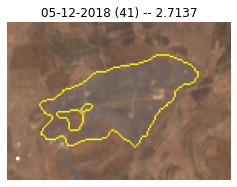

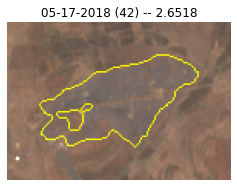

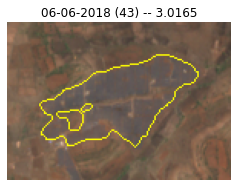

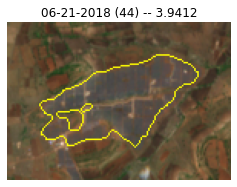

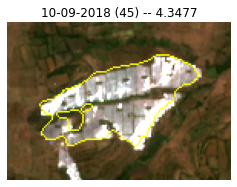

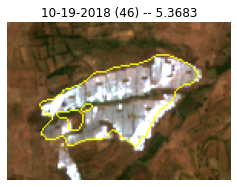

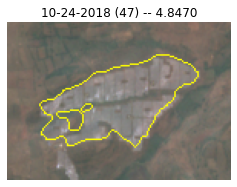

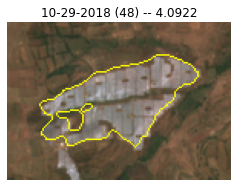

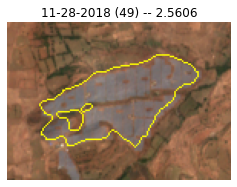

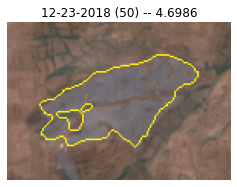

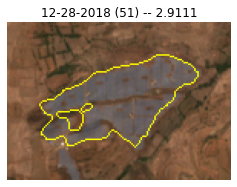

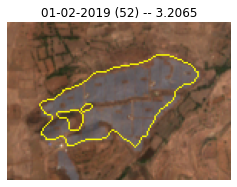

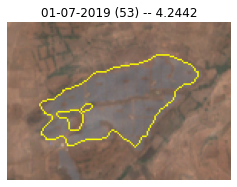

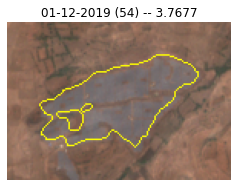

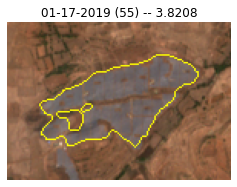

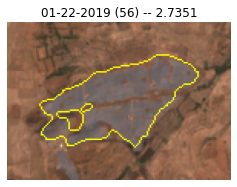

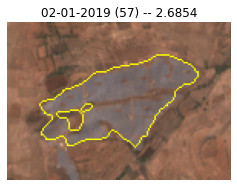

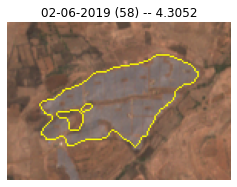

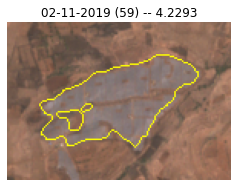

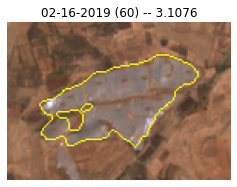

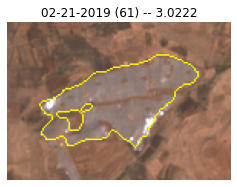

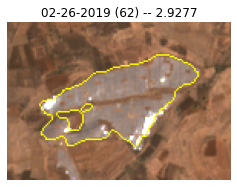

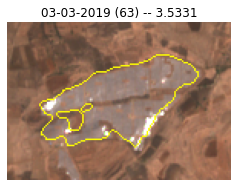

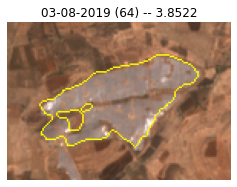

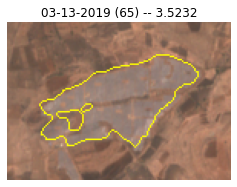

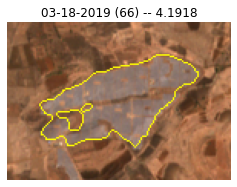

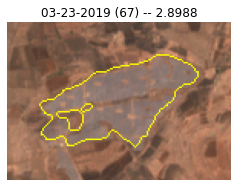

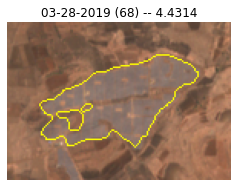

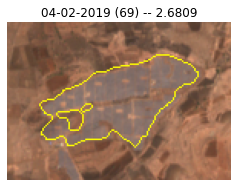

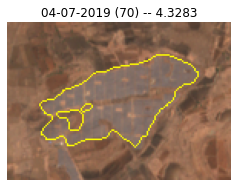

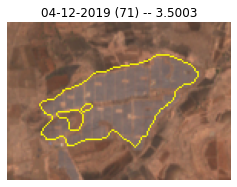

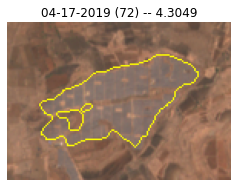

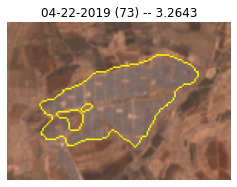

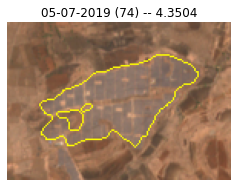

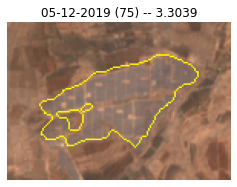

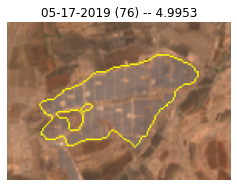

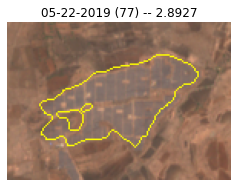

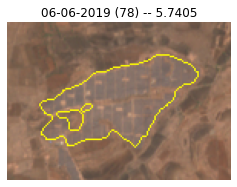

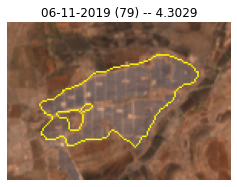

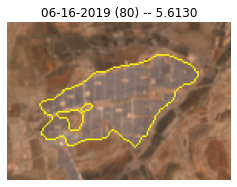

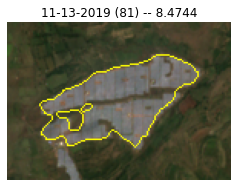

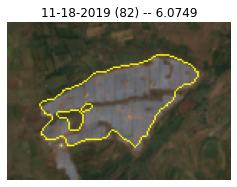

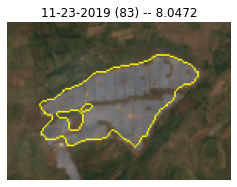

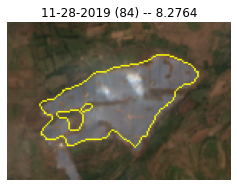

In [9]:
for i in range(len(dates)):
    plt.figure(figsize=(4,3))
    plt.imshow(rgb_images[i])
    plt.axis("off")
    plt.title(f"{dates[i]} ({i}) -- {divergence_values[i]:0.4f}")
    plt.show()
    plt.close()

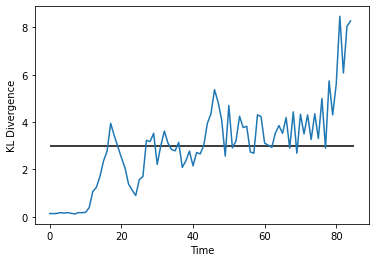

In [10]:
plt.figure()
plt.plot(divergence_values)
plt.hlines(y=np.median(divergence_values), xmin=0, xmax=len(divergence_values), color='k')
plt.xlabel("Time")
plt.ylabel("KL Divergence")
plt.show()
plt.close()

In [11]:
def running_mean(x, N):
    # from: https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

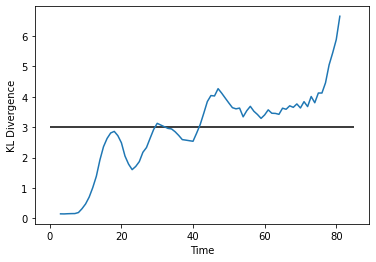

In [12]:
window = 7
half_window = window//2
smoothed_divergence_values = running_mean(divergence_values,window)
plt.figure()
plt.plot(range(half_window,len(divergence_values)-half_window), smoothed_divergence_values)
plt.hlines(y=np.median(divergence_values), xmin=0, xmax=len(divergence_values), color='k')
plt.xlabel("Time")
plt.ylabel("KL Divergence")
plt.show()
plt.close()

## Generate GIF

In [13]:
!mkdir -p temp/

In [14]:
for i in range(len(dates)):
    plt.figure()
    plt.imshow(rgb_images[i])
    plt.axis("off")
    plt.title(dates[i],fontsize=18)
    plt.savefig("temp/%d.jpg" % (i))
    plt.close()

In [15]:
images = []
for i in range(len(dates)):
    image = imageio.imread("temp/%d.jpg" % (i))
    images.append(image)

In [16]:
imageio.mimsave("test.gif", images, fps=3)
optimize("test.gif")

In [17]:
!rm -rf temp/